In [13]:
%matplotlib inline 
from time import time

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn import svm
from sklearn.datasets import make_classification
from sklearn import datasets
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

import numpy as np

import seaborn as sns
sns.set()

In [2]:
X, y = datasets.make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn');

In [2]:
def plot_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    
    x = np.linspace(x_lim[0],x_lim[1],40)
    y = np.linspace(y_lim[0],y_lim[1],40)
    X, Y = np.meshgrid(x,y)
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    ax.contour(X, Y, P, colors='k',
        levels=[-1, 0, 1], alpha=0.5,
        linestyles=['--', '-', '--'])
    
    ax.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, linewidth=1, facecolors='none');
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)  

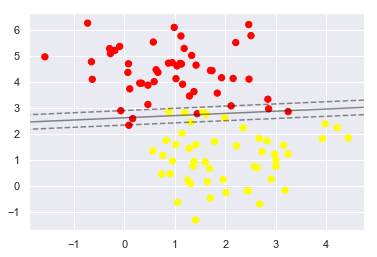

In [4]:
model = svm.SVC(kernel='linear', C=100)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn')
plot_decision_function(model)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


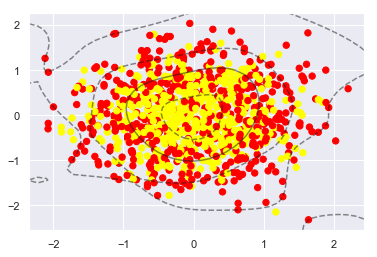

In [8]:
X, y = datasets.make_circles(1000, factor=.5, noise=.5)
svm_rbf = (gamma=1,C=1).fit(X, y)
print(svm_rbf)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn')
plot_decision_function(svm_rbf);

SVC(C=71, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
24
0.961
{'kernel': 'rbf', 'C': 71, 'gamma': 0.001}


/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


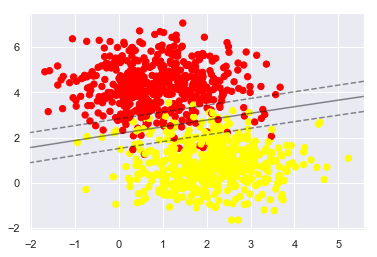

In [4]:
# paramters optimization
# For grid search
param_grid = [
 {'C': range(1,100,10), 'kernel': ['linear']},
 {'C': range(1,100,10), 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

# For random search
#param_grid = [{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
#  'kernel': ['rbf'], 'class_weight':['balanced', None]}]

# Can use continous or discrete function for random search
# Normally sklearn.metrics.accuracy_score for classification  
# and sklearn.metrics.r2_score for regression are used
# An alternative scoring algorithm can be used
# Can use multiple scoring algorithms

X, y = datasets.make_blobs(n_samples=1000, centers=2,
                  random_state=0, cluster_std=1)


# X, y = make_hastie_10_2(n_samples=8000, random_state=42)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
gs = GridSearchCV(svm.SVC(),
                   param_grid=param_grid,
                   scoring=scoring, cv=5, refit='Accuracy', return_train_score=True)
gs.fit(X, y)
estimator = gs.best_estimator_
print(estimator)
print(gs.best_index_)
print(gs.best_score_)
print(gs.best_params_)
results = gs.cv_results_

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn')
plot_decision_function(gs.best_estimator_);


plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [14]:
newsgroups_train = fetch_20newsgroups_vectorized(subset='train')
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.5)
print(lfw_people.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']


In [20]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1,10,100,1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.176s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.019s
Fitting the classifier to the training set


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 87.061s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.060s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.81      0.90      0.85        60
  Donald Rumsfeld       0.72      0.78      0.75        27
    George W Bush       0.94      0.89      0.92       146
Gerhard Schroeder       0.67      0.80      0.73        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.91      0.81      0.85        36

        micro avg       0.84      0.84      0.84       322
        macro avg       0.78      0.78      0.78       322
     weighted avg       0.85      0.84      0.85       322

[[ 10   0

In [22]:
def contour_parameter(loss,lambdas,gammas):
    C, G = np.meshgrid(lambdas, gammas)
    plt.figure()
    cp = plt.contourf(C, G, np.array(loss).reshape(C.shape))
    plt.colorbar(cp)
    plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
    plt.xlabel('$C$')
    plt.ylabel('$\gamma')
    plt.show()
    

In [23]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.25, random_state=42)

def sample_loss(params):
    return cross_val_score(svm.SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=X_train, y=y_train, scoring='roc_auc', cv=3).mean()


# clf = svm.SVC(C=10 ** 1, gamma=10 ** 0.01, random_state=12345)
# clf.fit(X_train,y_train)
# score = cross_val_score(clf,X=X_train, y=y_train, scoring='roc_auc', cv=5)

lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])
real_loss = [sample_loss(params) for params in param_grid]

print(real_loss)



# pipeline = Pipeline([
#     ('svm', svm.SVC())
# ])

# param_grid = [
#  {'svm__C': range(1,100,10), 'svm__kernel': ['linear']},
#  {'svm__C': range(1,100,10), 'svm__gamma': [0.001, 0.0001], 'svm__kernel': ['rbf']},
# ]


# grid_search = GridSearchCV(pipeline,
#                    param_grid=param_grid, cv=5,n_jobs=-1, verbose=1, return_train_score=True)

# grid_search.fit(X_train, y_train)

# print(grid_search.best_estimator_)
# best_parameters = grid_search.best_estimator_.get_params()
# print(best_parameters)



[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6616651288006823, 0.6616651288006823, 0.6616651288006823, 0.6616651288006823, 0.6616668306444599, 0.6277147503149286, 0.6102489541991596, 0.586044827709877, 0.5772480475402957, 0.5669058438800088, 0.5612177118959024, 0.553958559734364, 0.5510783226887633, 0.5447343494884357, 0.5382650864085913, 0.532755572694935, 0.530758200303531, 0.5287109821027481, 0.5251820630472451

In [26]:
%run ./bayes_optimizer/bayesian_optimization.py
%run ./plotter.py
contour_parameter(real_loss,lambdas,gammas)

<Figure size 432x288 with 0 Axes>

In [27]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

/usr/local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3.52801684e-05]), 'nit': 5, 'funcalls': 54}
  ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([1.34837581e-05]), 'nit': 8, 'funcalls': 57}
  ConvergenceWarning)


In [32]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
print(lfw_people.target_names)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


In [31]:
# from 
# plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.58333333, -2.15789474])